In [1]:
import json
from collections import Counter
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pickle

In [2]:
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
nltk.download('stopwords')

In [5]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:40, 1993.35it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### 1.1 Посчитайте количество отзывов в разных городах и на разные банки

In [53]:
cities = []
banks = []
for response in responses:
    cities.append(response['city'])
    banks.append(response['bank_name'])

In [54]:
responses_cities = Counter(cities)
responses_banks = Counter(banks)

In [55]:
for i in responses_cities.most_common(10):
    print(i)

('г. Москва', 55354)
(None, 15174)
('г. Санкт-Петербург', 14342)
('г. Екатеринбург', 2337)
('г. Новосибирск', 2300)
('г. Нижний Новгород', 1976)
('г. Ростов-на-Дону', 1891)
('г. Самара', 1731)
('г. Челябинск', 1507)
('г. Казань', 1440)


In [56]:
for i in responses_banks.most_common(10):
    print(i)

('Сбербанк России', 26327)
('Альфа-Банк', 10224)
('ВТБ 24', 8185)
('Русский Стандарт', 7943)
('Хоум Кредит Банк', 7549)
('Тинькофф Банк', 5387)
('Национальный Банк «Траст»', 4607)
('Ренессанс Кредит', 3849)
('Связной Банк', 3775)
('ОТП Банк', 3237)


### 1.2. Постройте гистограмы длин слов в символах и в словах

#### Построим гистограмы длин слов в символах (больше 10 символов)

In [4]:
max_word =''
words=[]
for response in tqdm(responses):  
    for word in response['text'].split():
        if len(word)> 10:
            words.append([word, len(word)])

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [00:19<00:00, 7766.09it/s]


In [14]:
w, l = zip(*words)

In [18]:
%%time
df = pd.DataFrame([w, l]).transpose()

Wall time: 6min 3s


#### выведем ТОП-10 длинных слов

In [84]:
df.sort_values(1, ascending=False)[:10]

,0,1
1068016,https://lh6.googleusercontent.com/-WzZ4rjBGzF4...,841
1068018,https://lh4.googleusercontent.com/-Bc0TG98kq2o...,827
1068017,https://lh5.googleusercontent.com/-c43qBWsTDYo...,827
1068019,https://lh5.googleusercontent.com/-0pEwr4EYYdI...,826
1068015,https://lh3.googleusercontent.com/-mnQjZF7m5uI...,797
1068014,https://lh6.googleusercontent.com/-DSPLatw_OYc...,796
1068025,https://lh6.googleusercontent.com/-pxOJwsPu68w...,539
1068010,https://lh5.googleusercontent.com/-jqJzUE4aETw...,448
1068022,https://lh6.googleusercontent.com/-JDKbeenWU8s...,406
1295751,https://www.dropbox.com/s/s8qfdm42d6zstnv/%D0%...,254


<AxesSubplot:>

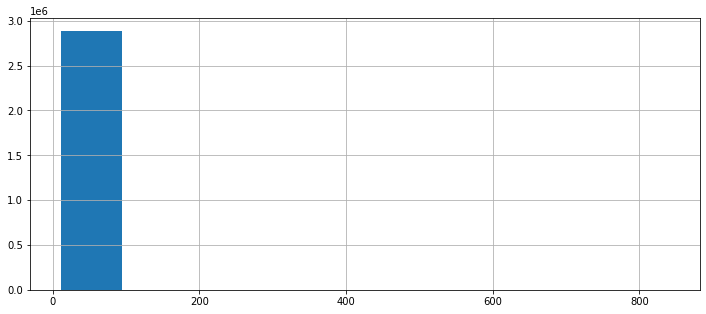

In [122]:
df[1].astype(int).hist(figsize=(12,5))

#### Построим гистограмы длин слов в словах

In [100]:
max_sentence =''
sentences=[]
for response in tqdm(responses):  
    if len(response['text'].split())> 1000:
        sentences.append([response['text'], len(response['text'].split())])

100%|███████████████████████████████████████████████████████████████████████| 153499/153499 [00:05<00:00, 26492.08it/s]


In [102]:
s, l = zip(*sentences)

In [103]:
%%time
df_sentenses = pd.DataFrame([s, l]).transpose()

Wall time: 216 ms


#### выведем ТОП-10 длинных предложений

In [112]:
df_sentenses.sort_values(1, ascending=False)[:10]

,0,1
386,"Доброго времени суток. Я, Ливанцов Денис Анато...",5000
1172,Весь пост (крайне объёмный) опубликован мной в...,4305
294,Введение оно же вывод. Данный отзыв содержит к...,4192
771,История за 10 лет... Напишу кратко (это действ...,4012
195,Как и обещал в своем предыдущем отзыве от 29 о...,3879
219,"Представьте себе такую ситуацию: Вы, ежедневн...",3614
1225,"Данное письмо разместил по просьбе автора, и о...",3416
1366,Подсадили нас на Сбербанк в организации. Орган...,3308
1338,Добрый вечер всем. Являюсь клиентом Филиала ОО...,3281
663,"Это мой первый отзыв на портале, посему прошу ...",3228


#### видно ограничение в 5000 слов на сайте

#### Выведем гистограмму длин сообщений длиной от 1000 слов

<AxesSubplot:>

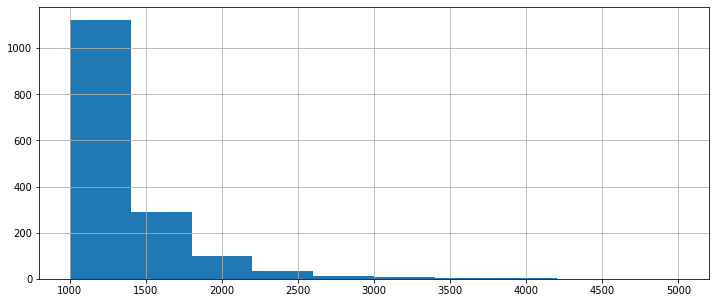

In [121]:
df_sentenses[1].astype(int).hist(figsize=(12,5))

### 1.3. Найдите 10 самых частых:
### * слов
### * слов без стоп-слов
### * лемм
### * существительных


### Найдите 10 самых частых слов

In [58]:
import re
regex = re.compile("[А-Яа-яA-Za-z]+")

In [49]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']


In [59]:
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [128]:
words = []
for response in tqdm(responses):
    text = response['text'].lower()
    text = words_only(text)
    words.extend(text.split(' '))

len(words)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [00:25<00:00, 5958.20it/s]


35674152

In [129]:
words_counter = Counter(words)
for i in words_counter.most_common(10):
    print(i)

('в', 1330535)
('и', 1058982)
('не', 855332)
('на', 707931)
('что', 640057)
('я', 577484)
('с', 463754)
('по', 372765)
('мне', 320958)
('банка', 275899)


### Найдите 10 самых частых слов без стоп-слов

In [60]:
words = []
for response in tqdm(responses):
    text = response['text'].lower()
    text = words_only(text)
    text = remove_stopwords(text)
    words.extend(text.split(' '))

len(words)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [02:09<00:00, 1189.83it/s]


22251313

In [61]:
words_counter = Counter(words)
words_counter.most_common(10)

[('банка', 275899),
 ('банк', 215411),
 ('деньги', 131200),
 ('карту', 105827),
 ('карты', 101821),
 ('кредит', 81119),
 ('день', 76552),
 ('банке', 72162),
 ('заявление', 70423),
 ('очень', 66824)]

### Найдите 10 самых частых лемм

In [133]:
from pymystem3 import Mystem
m = Mystem()

In [134]:
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [63]:
%%time
lemmatized_text = ''
step =200000
for i in tqdm(range(0, len(words), step)):
    words_str = ' '.join(words[i:i+step])
    text_to_lematize = lemmatize(words_str)
    if i ==0:
        lemmatized_text = text_to_lematize
    else:
        lemmatized_text = ' '.join([lemmatized_text, text_to_lematize])
len(lemmatized_text)

100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [29:56<00:00, 16.18s/it]

Wall time: 29min 56s


177973995

In [7]:
lemmata = lemmatized_text.split()

In [8]:
lemmata_counter = Counter(lemmata)

In [9]:
lemmata_counter.most_common(10)


[('банк', 621048),
 ('карта', 334998),
 ('деньги', 179734),
 ('день', 173065),
 ('кредит', 156177),
 ('отделение', 144050),
 ('весь', 144041),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счет', 126894)]

### Найдите 10 самых частых существительных

In [4]:
from ufal.udpipe import Model, Pipeline

In [5]:
model = Model.load("russian-ud-2.0-170801.udpipe") # path to the model

In [20]:
TOP_100_lemm_with_counts = lemmata_counter.most_common(100)
TOP_100_lemm_list = list(zip(*TOP_100_lemm_with_counts))[0]
TOP_100_lemm = ' '.join(TOP_100_lemm_list)

In [22]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = "Если бы мне платили каждый раз. Каждый раз, когда я думаю о тебе."
parsed = pipeline.process(TOP_100_lemm)


In [24]:
nouns = ''
for l in parsed.split('\n'):
    if l.find('NOUN') != -1:
        nouns = ' '.join([nouns, l.split('\t')[2].lower()])

In [26]:
nouns.split()[:10]

['банк',
 'карта',
 'деньги',
 'день',
 'отделение',
 'клиент',
 'сотрудник',
 'сумма',
 'заявление',
 'год']

### 1.4. Постройте кривые Ципфа и Хипса


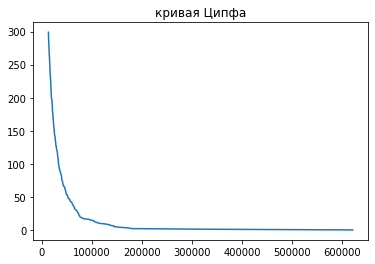

In [38]:
freqs = list(lemmata_counter.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
ax.set_title('кривая Ципфа')
plt.show()

In [19]:
from string import punctuation
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

In [60]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df_responses.iterrows(), total = len(df_responses)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [22:53<00:00, 111.72it/s]


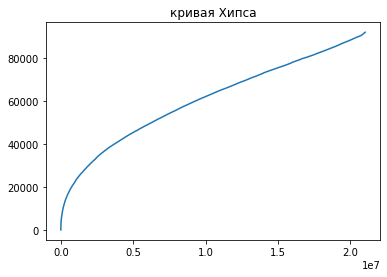

In [61]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
ax.set_title('кривая Хипса')
plt.show()

### 1.5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [18]:
print(f'сотрудник: {sum(df_responses.text.str.contains("сотрудник"))}')
print(f'клиент: {sum(df_responses.text.str.contains("клиент"))}')
print(f'мошенничество: {sum(df_responses.text.str.contains("мошенничество"))}')
print(f'доверие: {sum(df_responses.text.str.contains("доверие"))}')                 

сотрудник: 61348
клиент: 69852
мошенничество: 2652
доверие: 2148


### 1.6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [24]:
df_responses2 = df_responses[df_responses.rating_grade.notnull()].copy()

#### Разделим на положительные и отрицательные

In [30]:
poz = df_responses2[df_responses2.rating_grade==5].copy()
neg = df_responses2[df_responses2.rating_grade==1].copy()

In [32]:
poz.shape, neg.shape

((14713, 10), (47387, 10))

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### Положительные униграммы

In [48]:
poz_vec = TfidfVectorizer(ngram_range=(1, 1))
poz_bow = poz_vec.fit_transform(poz.text)
list(poz_vec.vocabulary_.items())[:20]

[('досрочно', 6965),
 ('закрывать', 8265),
 ('вклад', 3530),
 ('отпуск', 19219),
 ('жена', 7611),
 ('заказывать', 8187),
 ('заранее', 8597),
 ('забывать', 7869),
 ('сотрудник', 28574),
 ('банк', 1404),
 ('спб', 28663),
 ('ленсовет', 12661),
 ('наталья', 15550),
 ('отказывать', 19041),
 ('хотя', 32833),
 ('сумма', 29514),
 ('значительный', 9086),
 ('работать', 24800),
 ('быстро', 2762),
 ('профессионально', 24380)]

#### Отрицательные униграммы

In [49]:
neg_vec = TfidfVectorizer(ngram_range=(1, 1))
neg_bow = neg_vec.fit_transform(neg.text)
list(neg_vec.vocabulary_.items())[:20]

[('открывать', 30276),
 ('вклад', 5476),
 ('счет', 47006),
 ('плюс', 33126),
 ('зарплатный', 13707),
 ('карта', 16567),
 ('рубль', 41795),
 ('сегодня', 43138),
 ('приходить', 37534),
 ('указанный', 49603),
 ('отделение', 30110),
 ('цель', 52180),
 ('пополнять', 35208),
 ('долларовый', 10744),
 ('сч', 46990),
 ('давать', 9150),
 ('операционист', 29272),
 ('паспорт', 31412),
 ('окошко', 28972),
 ('написать', 24008)]

#### Положительные биграммы

In [50]:
poz_vec = TfidfVectorizer(ngram_range=(2, 2))
poz_bow = poz_vec.fit_transform(poz.text)
list(poz_vec.vocabulary_.items())[:20]

[('досрочно закрывать', 161053),
 ('закрывать вклад', 187900),
 ('вклад отпуск', 67581),
 ('отпуск жена', 431380),
 ('жена заказывать', 175937),
 ('заказывать заранее', 186294),
 ('заранее забывать', 196189),
 ('забывать заказывать', 180256),
 ('заказывать сотрудник', 186508),
 ('сотрудник банк', 675091),
 ('банк спб', 22573),
 ('спб ленсовет', 680725),
 ('ленсовет наталья', 280700),
 ('наталья отказывать', 336409),
 ('отказывать хотя', 423533),
 ('хотя сумма', 776192),
 ('сумма значительный', 706380),
 ('значительный работать', 209600),
 ('работать быстро', 586271),
 ('быстро профессионально', 46029)]

#### Отрицательные биграммы

In [51]:
neg_vec = TfidfVectorizer(ngram_range=(2, 2))
neg_bow = neg_vec.fit_transform(neg.text)
list(neg_vec.vocabulary_.items())[:20]

[('открывать вклад', 1064439),
 ('вклад счет', 158298),
 ('счет плюс', 1785077),
 ('плюс зарплатный', 1176218),
 ('зарплатный карта', 488720),
 ('карта рубль', 601843),
 ('рубль сегодня', 1549870),
 ('сегодня приходить', 1596767),
 ('приходить указанный', 1381882),
 ('указанный отделение', 1872859),
 ('отделение цель', 1053291),
 ('цель пополнять', 1955660),
 ('пополнять долларовый', 1272377),
 ('долларовый сч', 381540),
 ('сч давать', 1780252),
 ('давать операционист', 298329),
 ('операционист паспорт', 1003827),
 ('паспорт зарплатный', 1118559),
 ('карта окошко', 600062),
 ('окошко написать', 991883)]

### Лемматизируем

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

### Предобработаем данные

In [8]:
df_responses = pd.DataFrame(responses)

In [158]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'р', 'руб', 'сумма',
    'который','прошлый','сей', 'свой', 'наш', 'ваш', 'мочь', 'такой', 'номер'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [159]:
%%time
df_responses.text = df_responses.text.progress_apply(remove_stopwords)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [01:26<00:00, 1776.46it/s]


Wall time: 1min 26s


### Построим модели с 5 и 30 темами

In [6]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [160]:
%%time
texts = [text.split() for text in df_responses.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Wall time: 1min


In [161]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [11]:
from gensim.models import lsimodel

In [162]:
%%time
lsi_5 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)
lsi_30 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 6min 57s


In [71]:
def custom_key(num): 
    return num[1]


In [163]:
topic_list_5 = []
for topic in lsi_5.show_topics():
    items = []
    for item in topic[1].split(' + '):
        if float(item.split('*')[0]) >0:
            k = [item.split('*')[1].replace('"',''), float(item.split('*')[0])]
            items.append(k)
    items.sort(key=custom_key, reverse=True)
    topic_list_5.append(items)


### Выведем темы со словами с наимольшим весом

#### для 5-ти тем

In [164]:
pd.DataFrame(topic_list_5)[0]

0       [карта, 0.2]
1    [кредит, 0.366]
2     [карта, 0.252]
3     [вклад, 0.313]
4    [звонок, 0.298]
Name: 0, dtype: object

#### для 30-ти тем

In [165]:
topic_list = []
for topic in lsi_30.show_topics():
    items = []
    for item in topic[1].split(' + '):
        if float(item.split('*')[0]) >0:
            k = [item.split('*')[1].replace('"',''), float(item.split('*')[0])]
            items.append(k)
    items.sort(key=custom_key, reverse=True)
    topic_list.append(items)

In [166]:
pd.DataFrame(topic_list)[0]

0           [карта, 0.2]
1      [банкомат, 0.275]
2      [банкомат, 0.219]
3         [вклад, 0.338]
4      [банкомат, 0.479]
5        [звонок, 0.242]
6      [сбербанк, 0.249]
7        [перевод, 0.27]
8      [банкомат, 0.332]
9     [страховка, 0.266]
10      [справка, 0.164]
11     [сбербанк, 0.429]
12     [терминал, 0.331]
13      [кошелек, 0.197]
14     [комиссия, 0.284]
15      [банкомат, 0.27]
16          [смс, 0.312]
17       [кредит, 0.307]
18      [договор, 0.281]
19     [комиссия, 0.362]
20     [терминал, 0.209]
21      [справка, 0.188]
22     [комиссия, 0.261]
23         [счет, 0.254]
24        [линия, 0.223]
25         [курс, 0.292]
26    [страховка, 0.345]
27       [звонок, 0.182]
28       [заявка, 0.198]
29    [заявление, 0.282]
Name: 0, dtype: object

#### В модели с 5-ю темами сами темы сильно различаются, в модели с 30-ю темами темы пересекаются. Возможно из-за того, что при большем количестве тем веса слов сильнее размываются.

#### Темы легко интерпретируемы и связаны с различными направлениями банковской деятельности: карточные операции, кредитование, вклады, звонки - это реклама либо мошенничество.

#### Тема со сбербанком встречается часто, т.к. это самый большй банк

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

#### Объединим в один Датасет положительные и отрицательные отзывы

In [90]:
poz_neg_df = poz.append(neg)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [9]:
x_train, x_test, y_train, y_test = train_test_split(poz_neg_df.text, poz_neg_df.rating_grade)

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### 1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

#### с униграммами

In [92]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

(0.7614170692431562, 0.8644391988489368)

#### с биграммами

In [93]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 51.6 s


(0.7615458937198067, 0.8646336112329969)

#### с триграммами

In [94]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,3))),
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 1min 25s


(0.7615458937198067, 0.8646336112329969)

#### с символьными униграммами

In [95]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 28.8 s


(0.7613526570048309, 0.8604182194287306)

### 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

#### с униграммами

In [98]:
%%time 
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,1))),
    ('LDA', LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 16min 46s


(0.8690499194847021, 0.872639985954322)

#### с биграммами

In [99]:
%%time 
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2))),
    ('LDA', LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 5min 55s


(0.7615458937198067, 0.8646336112329969)

#### с триграммами

In [14]:
%%time 
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,3))),
    ('LDA', LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=2)), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 6min 34s


(0.7605797101449275, 0.8640105367138623)

#### с символьными униграммами

In [101]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range=(1,1))),
    ('LDA', LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)), 
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test), f1_score(pred, y_test, average='weighted')

Wall time: 12min 59s


(0.7747504025764895, 0.8280900209477671)